In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, funksvd, basic, item_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
import math

In [4]:
ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [5]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
items['year'] = items.title.str.extract("\((\d{4})\)", expand=True)
items.year = pd.to_datetime(items.year, format='%Y')
items.year = items.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
items.title = items.title.str[:-7]

In [6]:
items['item'].count()

9125

In [7]:
genres_unique = pd.DataFrame(items.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
items = items.join(items.genres.str.get_dummies().astype(bool))
items.drop('genres', inplace=True, axis=1)

items['item'].count()

9125

In [8]:
# Organise a bit, then save into feather-formatand clear from memory
items.sort_values(by='item', inplace=True)
ratings.sort_values(by='item', inplace=True)
items.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

In [9]:
#items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
#items_dummy.head()

In [10]:
items['item'].count()

9125

In [ ]:
#joined = ratings.join(items.set_index('item'), on='item')

In [ ]:
#items.groupby('Action').mean()

In [ ]:
#items[''].value_counts()

In [ ]:
#Most rated films in titles
#most_rated = items.groupby('title').size().sort_values(ascending=False)[:25]

In [ ]:
#ratings = joined.loc[joined['genres'].isin(['Adventure', 'Children', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'IMAX', 'Mystery', 'Sci-Fi', 'Animation', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Musical', 'Action'])]


#mean_ratings = ratings.groupby(['genres'], as_index=False)['rating'].aggregate(np.mean)
#mean_ratings

In [ ]:
#average_ratings = ratings.groupby(['genres'], as_index=False)['rating'].aggregate(np.average)
#average_ratings

In [ ]:
#count_ratings = ratings.groupby(['genres'], as_index=False)['rating'].count()
#count_ratings

In [ ]:
#items_ = joined.loc[joined['genres'].isin(['Adventure', 'Children', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'IMAX', 'Mystery', 'Sci-Fi', 'Animation', 'Comedy', 'Romance', 'Thriller', 'Horror', 'Musical', 'Action'])]

In [ ]:
#ount_items = items_.groupby(['genres'], as_index=False)['item'].count()
#count_items

Cumulative number of movies, in total and per genre.
As we can derive, that Comedy and Drama are the top genred represented in the dataset.


<Figure size 720x360 with 0 Axes>

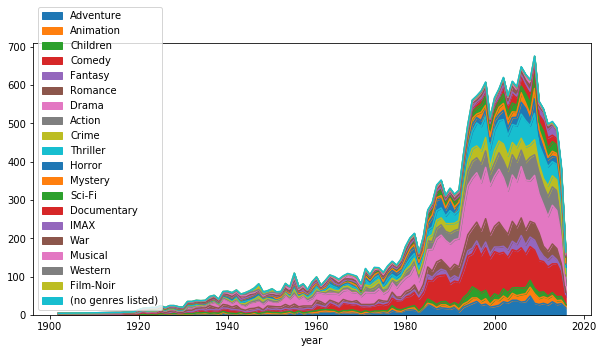

In [91]:
plt.figure(figsize=(10,5))
items_grouped = items[['item', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : items_grouped.item.nunique()})


for genre in genres_unique.genre:
    items_grouped = items[items[genre]][['item', 'year']].groupby('year')
    df[genre]=items_grouped.item.nunique()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))

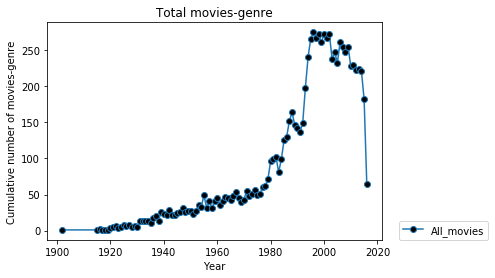

In [63]:
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()

In [64]:
df.head()



,All_movies,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
year,,,,,,,,,,,,,,,,,,,,,
1902.0,1,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915.0,1,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1916.0,2,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1917.0,1,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1918.0,1,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [80]:
df.iloc[-1].count()

21

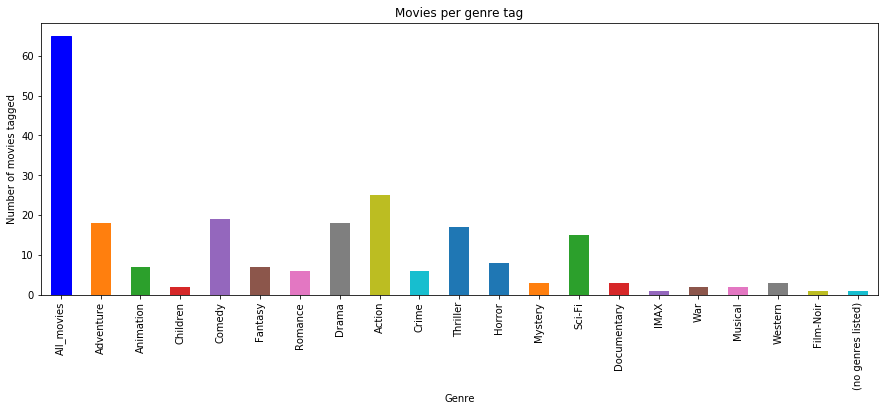

In [79]:


# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

In [57]:
items['item'].count()

9125

Next, we want to see the distributions by genre, on top of total rating distribtution for helping to identifying consistent ratings or outliers (e.g. Comedies being rated higher in general). We can derive, that all genres show a similar pattern. The Horror movies are a bit skewed to the left (which means poorer ratings).

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


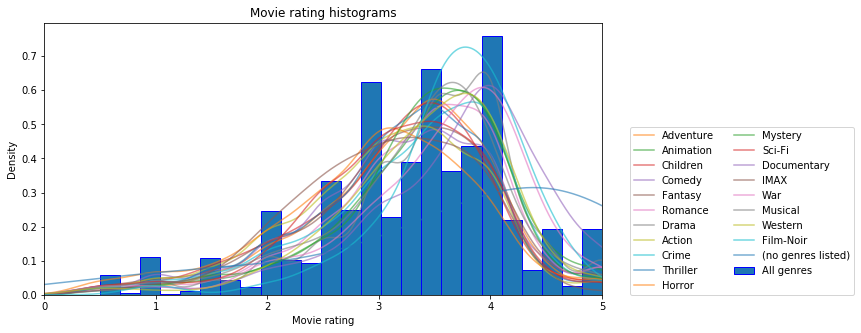

In [93]:
dftmp = ratings[['item','rating']].groupby('item').mean()

# Initialize empty list to capture basic stats by genre
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', normed=True, label ='All genres', figsize=(10,5))

# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = items[items[genre]==True]
    dftmp = ratings[ratings.set_index('item').index.isin(dftmp.set_index('item').index)]
    dftmp = dftmp[['item','rating']].groupby('item').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

Try to compute basic statistics (avg and std) for each genre. 

In [68]:
# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)

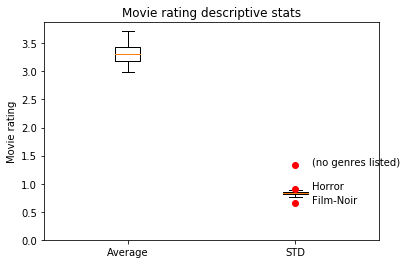

In [69]:
#Boxplot with outliers
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")

# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

In [70]:
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()


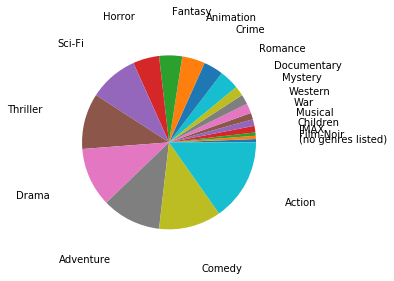

In [71]:
#Pie chart to visualize how 4 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()